# A4.1: Predicting gaze-selection performance time

In [84]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import jupyter_module_loader
jupyter_module_loader.register()

To reuse functions in notebook, I import both notebook1c and notebook2c

In [75]:
import notebook1c as m1
import notebook2c as m2

## Move duration
I give two hypothetical values: the speed of saccade and the duration of fixations.  
People try to move their eyes to the target, in each trial, the move duration is the sum of the saccades and the fixations.

In [85]:
def agent( belief, state, bounds, stop ):
    num_fixations = 0
    # loop until the gaze is on the target location
    done = False
    move_duration = 0
    while not done:
        action = m2.controller( belief )
        state = m1.environment( state, action, bounds )
        obs = m1.observation( state, bounds )
        belief = m2.state_estimate( belief, obs )

        saccade_speed = 30 # per second
        saccade_time = obs['target_est'] / saccade_speed # linearly related to the distance
#         saccade_speed = np.random.normal( 0, bounds['saccade_noise'] * saccade_speed, 1) + saccade_speed
#       print(saccade_speed)
        
        fixation_duration = 0.5 # seconds
#         fixation_duration = np.random.normal( 0, bounds['fixation_noise'] * fixation_duration, 1) + fixation_duration
#       print(fixation_duration 
        move_duration += saccade_time + fixation_duration
    
        num_fixations += 1
        done = stop(state)
    return move_duration

We can test the agent by calling it with the prior and a random state.

In [93]:
agent( m2.init_prior(), m1.init_random_state(m1.task_env), m1.init_bounds(), m1.terminate )

2.4328811134232096

## Bounds

Next we add bounds to the model for the saccade_speed and the fixation_duration

In [94]:
def init_bounds():
    return {'ocular_noise': 0.1,
            'perceptual_noise': 0.05,
            'fixation_noise': 0.1,
            'saccade_noise': 0.1}

Now we can get a new agent.

In [98]:
def agent( belief, state, bounds, stop ):
    num_fixations = 0
    # loop until the gaze is on the target location
    done = False
    move_duration = 0
    while not done:
        action = m2.controller( belief )
        state = m1.environment( state, action, bounds )
        obs = m1.observation( state, bounds )
        belief = m2.state_estimate( belief, obs )

        saccade_speed = 30 # per second
        saccade_random_offset = np.random.normal( 0, bounds['saccade_noise'] * saccade_speed, 1)
        saccade_time = obs['target_est'] / (saccade_speed + saccade_random_offset) # linearly related to the distance
        # print(saccade_speed)
        
        fixation_duration = 0.5 # seconds
        fixation_random_offset = np.random.normal( 0, bounds['fixation_noise'] * fixation_duration, 1)
        fixation_duration += fixation_random_offset
#       print(fixation_duration)
        move_duration += saccade_time + fixation_duration
    
        num_fixations += 1
        done = stop(state)
    return move_duration

In [97]:
agent( m2.init_prior(), m1.init_random_state(m1.task_env), init_bounds(), m1.terminate )

array([2.90702961])

## Test model

prior:{'location': 30, 'uncertainty': 5, 'at_target': False}
task_env:{'location_mean': 30, 'location_SD': 5, 'width_min': 2, 'width_max': 8}
bounds:{'ocular_noise': 0.1, 'perceptual_noise': 0.05, 'fixation_noise': 0.1, 'saccade_noise': 0.1}
example random state:{'target_loc': 27.6156522401034, 'target_width': 4.679331906623484, 'gaze_loc': 0}


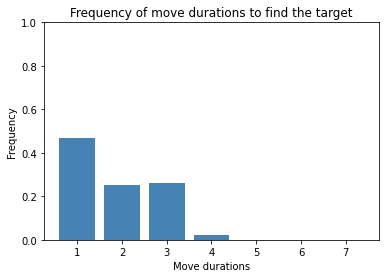

In [99]:
def test_model( prior, state, bounds, n_trials=10 ):
    fixation_list=[]
    for trial in range(n_trials):
        results = agent( prior, state, bounds, m1.terminate )
        fixation_list.append( results )
    return fixation_list

list_move_duration = []
for i in range(100):
    state = m1.init_random_state(m1.task_env)
    list_move_duration.append(np.mean(test_model( m2.init_prior(), state, init_bounds(), n_trials=100 )))

print("prior:" + str(init_prior()))
print("task_env:" + str(m1.task_env))
print("bounds:" + str(init_bounds()))
print("example random state:" + str(m1.init_random_state(m1.task_env)))

m = len(list_move_duration)
plt.hist(list_move_duration, color='steelblue', weights=np.ones(m)/m, align='left', rwidth=0.8, bins=[1,2,3,4,5,6,7,8])
plt.ylim(top=1)
plt.xlabel("Move durations")
plt.ylabel("Frequency")
plt.title("Frequency of move durations to find the target")
plt.show()

We could find that the distribution of move duration from the graph below. The most frequency of move durations is at 1 and reduces with move duration increases

## Effect of width

We can use the model to predict the effect of width on the move duration.

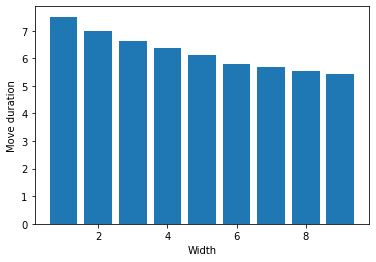

In [73]:
list_move_duration = []
widths = list(range(1,10))
for width in widths:
    state = {'target_loc': 60, 'target_width': width, 'gaze_loc': 0}
    prior = {'location': 30, 'uncertainty': 50, 'at_target': False}
    list_move_duration.append(np.mean(test_model( prior, state, init_bounds(), n_trials=500 )))

plt.bar(widths, list_move_duration)
plt.xlabel("Width")
plt.ylabel("Move duration")
plt.show()

As for width increases, we can see the move duration decreases. Because the increasing width causes the reduction of the number of fixations.

## Effect of distance

We can predict the effect of distance on the number of fixations.

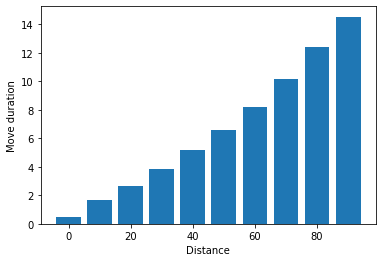

In [70]:
list_move_duration = []
locations = list(range(0,100,10))
for location in locations:
    state = {'target_loc': location, 'target_width': 5, 'gaze_loc': 150}
    prior = {'location': 0, 'uncertainty': 5, 'at_target': False}
    list_move_duration.append(np.mean(test_model( prior, state, init_bounds(), n_trials=500 )))

plt.bar(locations, list_move_duration, width=8)
plt.xlabel("Distance")
plt.ylabel("Move duration")
plt.show()

As for distance increases, the move duration is approximately logarithmic growth. Because both the saccade time and the number of fixations increase.

## Discussion

Assess the behaviour of the model. Does it work well? How could it be improved? How does it compare to Fitts’ Law as a model of human cognition?

I think the model works well. It has considered both the saccade time and fixation duration. However, I guess the saccade time may not be linearly related to the distance moved. For example, there may be diraction factor that could influence the time. The relation should be measured. And I also think that in state estimation process, we could consider the saccade speed. According to previous observation, people may be more familiar with the target so the saccade speed may be increased.  
Compared to Fitts' Law, I think the new model is better. Because Fitts' Law doesn't consider the fixation duration. And Fitts' Law assumes that user can focus on the target in one attempt. The new model consider more noise in environment that would influence the result. So I think the new model is more practical in real life.